In [20]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from tqdm import tqdm
from IPython import display
print('Tensorflow version : ', tf.__version__)


Tensorflow version :  2.16.2


In [21]:
(x_train,y_train),(x_test,y_test)=tf.keras.datasets.fashion_mnist.load_data()
x_train=((x_train.astype(np.float32)/255.0)*2.0 - 1.0)[..., np.newaxis]
x_test=((x_test.astype(np.float32)/255.0)*2.0 - 1.0)[..., np.newaxis]
x_train.shape,x_test.shape

((60000, 28, 28), (10000, 28, 28))

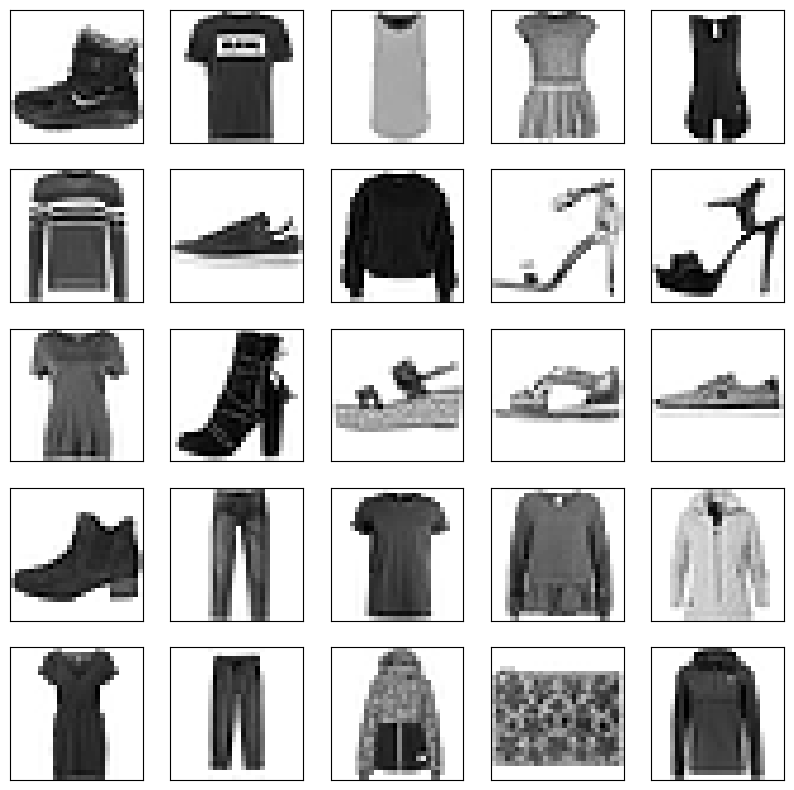

In [22]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(((x_train[i]+1.0)/2.0).squeeze(-1),cmap=plt.cm.binary)
plt.show()

training parameters defining 

In [23]:
batch_size=32 
def create_batch(x_train):
    dataset=tf.data.Dataset.from_tensor_slices(x_train).shuffle(1000)
    dataset=dataset.batch(batch_size,drop_remainder=True).prefetch(1)

    return dataset 


In [25]:
num_features=1000 

generator=keras.models.Sequential([
    keras.layers.Dense(7*7*128, input_shape=[num_features]),
    keras.layers.Reshape([7, 7, 128]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(
        64, (5, 5), (2, 2), padding="same", activation="selu"
    ),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(
        1, (5, 5), (2, 2), padding="same", activation="tanh"
    ),
])

generator.summary()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 6272)           │     6,278,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 14, 14, 64)     │       204,864 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 28, 28, 1)      │         1,601 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,485,505 (24.74 MB)

 Trainable params: 6,485,121 (24.74 MB)

 Non-trainable params: 384 (1.50 KB)

In [26]:
discriminator = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28, 1]),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(1, activation="sigmoid"),
])

discriminator.summary()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 100,609 (393.00 KB)

 Trainable params: 100,609 (393.00 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
# Compile discriminator standalone
discriminator.compile(
    optimizer=keras.optimizers.Adam(),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

# When training the combined model, freeze discriminator weights
discriminator.trainable = False

# Combined GAN: generator feeding into the frozen discriminator
gan = keras.models.Sequential([generator, discriminator])
gan.compile(
    optimizer=keras.optimizers.Adam(),
    loss="binary_crossentropy",
)


In [41]:
import tensorflow as tf
from tqdm.auto import tqdm

epochs = 10
dataset = create_batch(x_train)

img_shape = x_train.shape[1:]  # (H, W, C)
steps_per_epoch = x_train.shape[0] // batch_size

for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    dataset_iter = iter(dataset)

    for step in tqdm(range(steps_per_epoch), leave=False):
        real_images = next(dataset_iter)
        real_images = tf.convert_to_tensor(real_images, dtype=tf.float32)

        batch_size_curr = tf.shape(real_images)[0]

        noise = tf.random.normal([batch_size_curr, num_features])
        fake_images = generator(noise, training=True)
        fake_images = tf.convert_to_tensor(fake_images, dtype=tf.float32)

        
        fake_images = tf.reshape(fake_images, (batch_size_curr, *img_shape))

        discriminator.trainable = True
        d_loss_real = discriminator.train_on_batch(real_images, tf.ones((batch_size_curr, 1)))
        d_loss_fake = discriminator.train_on_batch(fake_images, tf.zeros((batch_size_curr, 1)))

        discriminator.trainable = False
        noise2 = tf.random.normal([batch_size_curr, num_features])
        g_loss = gan.train_on_batch(noise2, tf.ones((batch_size_curr, 1)))

    print(f"D loss real: {d_loss_real} | D loss fake: {d_loss_fake} | G loss: {g_loss}")


Epoch 1/10


D loss real: [array(0.33907822, dtype=float32), array(0.8708162, dtype=float32)] | D loss fake: [array(0.33904377, dtype=float32), array(0.8708422, dtype=float32)] | G loss: 2.4394168853759766
Epoch 2/10


D loss real: [array(0.33431122, dtype=float32), array(0.8718196, dtype=float32)] | D loss fake: [array(0.33430952, dtype=float32), array(0.8718242, dtype=float32)] | G loss: 2.15240740776062
Epoch 3/10


D loss real: [array(0.32120603, dtype=float32), array(0.8758467, dtype=float32)] | D loss fake: [array(0.32121125, dtype=float32), array(0.8758383, dtype=float32)] | G loss: 2.143676996231079
Epoch 4/10


D loss real: [array(0.31026575, dtype=float32), array(0.87957287, dtype=float32)] | D loss fake: [array(0.31026584, dtype=float32), array(0.87957466, dtype=float32)] | G loss: 2.170283794403076
Epoch 5/10


D loss real: [array(0.3014335, dtype=float32), array(0.88285375, dtype=float32)] | D loss fake: [array(0.30142984, dtype=float32), array(0.88285834, dtype=float32)] | G loss: 2.2013659477233887
Epoch 6/10


D loss real: [array(0.29318497, dtype=float32), array(0.886216, dtype=float32)] | D loss fake: [array(0.2931796, dtype=float32), array(0.88621825, dtype=float32)] | G loss: 2.234382390975952
Epoch 7/10


D loss real: [array(0.2859265, dtype=float32), array(0.8891617, dtype=float32)] | D loss fake: [array(0.28591973, dtype=float32), array(0.88916594, dtype=float32)] | G loss: 2.272637128829956
Epoch 8/10


D loss real: [array(0.27911332, dtype=float32), array(0.8920054, dtype=float32)] | D loss fake: [array(0.27911466, dtype=float32), array(0.8920038, dtype=float32)] | G loss: 2.3050200939178467
Epoch 9/10


D loss real: [array(0.2731188, dtype=float32), array(0.8944441, dtype=float32)] | D loss fake: [array(0.27311528, dtype=float32), array(0.89444447, dtype=float32)] | G loss: 2.3393492698669434
Epoch 10/10


D loss real: [array(0.2663865, dtype=float32), array(0.8974083, dtype=float32)] | D loss fake: [array(0.26638114, dtype=float32), array(0.89741105, dtype=float32)] | G loss: 2.3779702186584473


In [44]:
import imageio
from pathlib import Path

def images_to_gif(image_dir, pattern='*.png', output_path='dcgan_samples.gif', fps=5):
    image_dir = Path(image_dir)
    frames = []
    for img_path in sorted(image_dir.glob(pattern)):
        frames.append(imageio.v3.imread(img_path))
    if not frames:
        raise ValueError(f'No images found in {image_dir} matching {pattern}')
    imageio.mimsave(output_path, frames, fps=fps)
    print(f'GIF saved to {output_path} ({len(frames)} frames, {fps} fps)')


In [43]:
! pip install imageio

In [ ]:
import matplotlib.pyplot as plt

def show_generated_samples(generator, num_rows=4, num_cols=4):
    total = num_rows * num_cols
    noise = tf.random.normal([total, num_features])
    imgs = generator(noise, training=False).numpy()
    imgs = (imgs + 1.0) / 2.0  # back to [0, 1]

    plt.figure(figsize=(num_cols*2, num_rows*2))
    for i in range(total):
        plt.subplot(num_rows, num_cols, i+1)
        plt.axis('off')
        plt.imshow(imgs[i].squeeze(), cmap='gray')
    plt.tight_layout()
    plt.show()




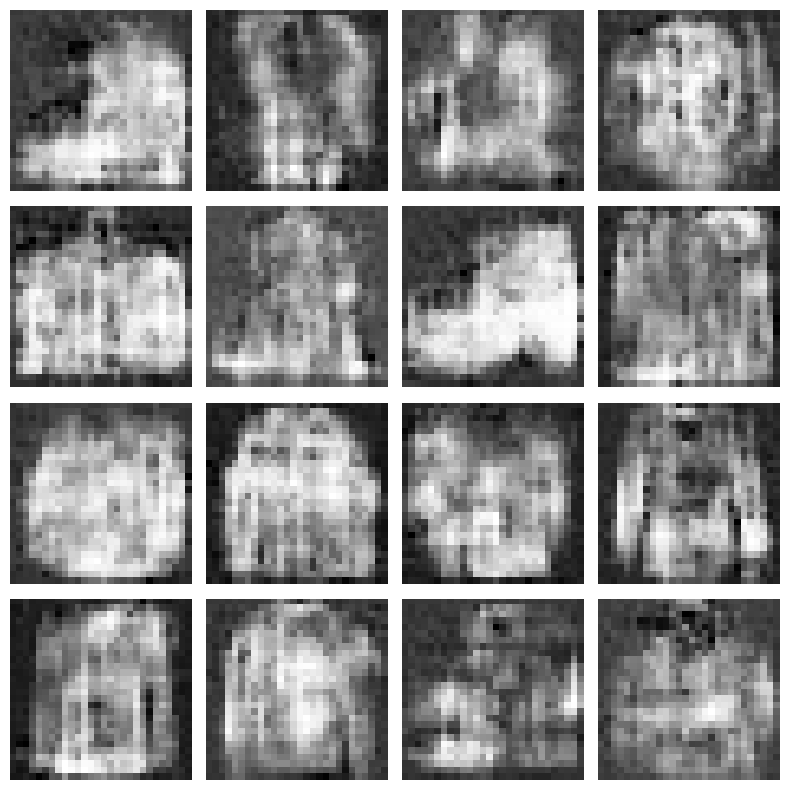

In [ ]:

show_generated_samples(generator, num_rows=4, num_cols=4)
